In [ ]:
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')


In [11]:
from google.colab import drive
import os
from zipfile import ZipFile
import numpy as np
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
import random

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/Pneumonia-Detection/chest_xray.zip"

# Check if ZIP file exists
if os.path.exists(zip_path):
    print("✅ ZIP file found!")
else:
    print("❌ ZIP file not found! Check the path.")

# Extract only valid image files
def is_image_file(file_name):
    if '__MACOSX' in file_name or file_name.startswith('._'):
        return False
    valid_extensions = ['.jpeg', '.jpg', '.png']
    return any(file_name.endswith(ext) for ext in valid_extensions)

# Extract image files from ZIP
with ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    image_files = [f for f in file_list if is_image_file(f)]

print(f"✅ Found {len(image_files)} valid images inside the ZIP!")

# Shuffle image files
random.shuffle(image_files)

# Define dataset split ratios
train_ratio = 0.7  # 70% training
val_ratio = 0.2    # 20% validation
test_ratio = 0.1   # 10% testing

# Compute split indices
train_index = int(len(image_files) * train_ratio)
val_index = int(len(image_files) * (train_ratio + val_ratio))

# Split dataset
train_image_files = image_files[:train_index]
val_image_files = image_files[train_index:val_index]
test_image_files = image_files[val_index:]

# ✅ Custom Data Generator (Fixed Version)
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, zip_path, file_paths, batch_size=16, target_size=(128, 128)):
        self.zip_path = zip_path
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.target_size = target_size

        # Store true labels (0 = NORMAL, 1 = PNEUMONIA)
        self.labels = np.array([0 if 'NORMAL' in f else 1 for f in file_paths])

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))  # ✅ Ensures last batch isn't dropped

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files)
        return X, y

    def __data_generation(self, batch_files):
        X = np.zeros((len(batch_files), *self.target_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_files),), dtype=np.int8)
        valid_count = 0

        with ZipFile(self.zip_path, 'r') as zip_ref:
            for file in batch_files:
                img = self.load_image_from_zip(zip_ref, file)
                if img is not None:
                    X[valid_count] = img
                    y[valid_count] = 1 if "PNEUMONIA" in file else 0  # ✅ Assign correct label
                    valid_count += 1

        return X[:valid_count], y[:valid_count]  # ✅ Trim extra space

    def load_image_from_zip(self, zip_ref, image_path):
        try:
            with zip_ref.open(image_path) as img_file:
                img = Image.open(img_file).convert("RGB")
                img = img.resize(self.target_size)  # Resize
                img = np.array(img, dtype=np.float32) / 255.0  # Normalize
            return img
        except (UnidentifiedImageError, OSError) as e:
            print(f"Skipping file {image_path} due to error: {e}")
            return None

    def get_labels(self):  # ✅ NEW METHOD: Returns all true labels
        return self.labels


# Filter out invalid image files for all sets
train_image_files = [file for file in train_image_files if is_image_file(file)]
val_image_files = [file for file in val_image_files if is_image_file(file)]
test_image_files = [file for file in test_image_files if is_image_file(file)]

# Create data generators
train_generator = CustomDataGenerator(zip_path=zip_path, file_paths=train_image_files, batch_size=16)
val_generator = CustomDataGenerator(zip_path=zip_path, file_paths=val_image_files, batch_size=16)
test_generator = CustomDataGenerator(zip_path=zip_path, file_paths=test_image_files, batch_size=16)

print(f"✅ Data generators ready: Train: {len(train_generator)} batches, Val: {len(val_generator)} batches, Test: {len(test_generator)} batches")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ ZIP file found!
✅ Found 11712 valid images inside the ZIP!
✅ Data generators ready: Train: 513 batches, Val: 147 batches, Test: 74 batches


In [17]:
#Initialize ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [18]:
##Compute class weights for the imbalanced classes (NORMAL and PNEUMONIA)
from sklearn.utils import class_weight
import numpy as np

# Assuming 'train_generator' has been created earlier from the ImageDataGenerator

# Initialize the list for storing labels (for class weight calculation)
y_train = []

# Loop through batches from the train_generator to extract labels for class weight computation
for i in range(len(train_generator)):  # Loop through the batches from the train generator
    _, labels = train_generator[i]  # Get a batch of labels (first item is the image batch, second is labels)
    y_train.append(labels)

# Flatten the list of batches into a single array
y_train = np.concatenate(y_train)

# Compute class weights for the imbalanced classes (0: NORMAL, 1: PNEUMONIA)
# The 'classes' parameter should be np.unique(y_train) and 'y' is the actual label array
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Map to class 0 and class 1 (NORMAL and PNEUMONIA)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weight dictionary:", class_weight_dict)



Class weight dictionary: {0: 1.875114364135407, 1: 0.6818030605455755}


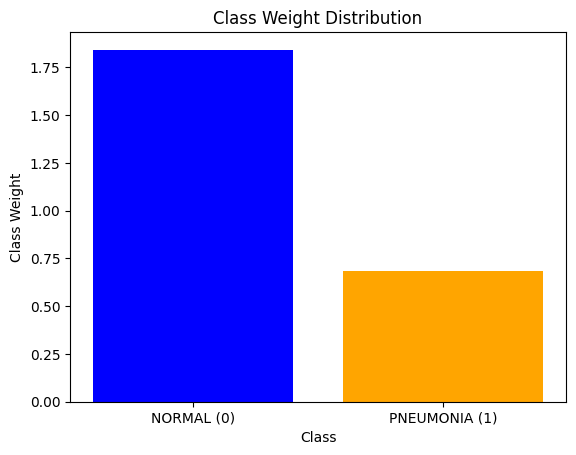

In [19]:
import matplotlib.pyplot as plt

# Class weight dictionary
class_weight_dict = {0: 1.8425196850393701, 1: 0.6862170087976539}

# Prepare data for plotting
classes = ['NORMAL (0)', 'PNEUMONIA (1)']
weights = [class_weight_dict[0], class_weight_dict[1]]

# Plotting the class weights
plt.bar(classes, weights, color=['blue', 'orange'])
plt.title('Class Weight Distribution')
plt.ylabel('Class Weight')
plt.xlabel('Class')

# Display the plot
plt.show()


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Build CNN model
model = Sequential([
    Input(shape=(128, 128, 3)),  # Explicitly define the input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),  # Reduced size
    Dropout(0.4),  # Added dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

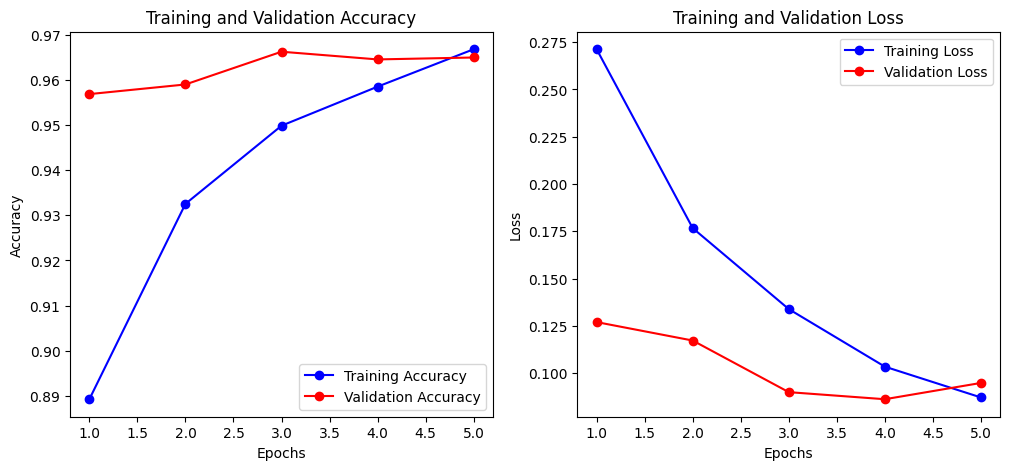

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Extract values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the graphs
plot_training_history(history)


In [ ]:
# Train the model using the training and validation generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weight_dict,  # Include class weights to handle imbalance
    verbose=1
)
# Save the entire model (architecture + weights + optimizer state)
model.save("/content/drive/MyDrive/Pneumonia-Detection/cnn_pneumonia_model.h5")
print("✅ Model saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.8284 - loss: 0.3907 - val_accuracy: 0.9191 - val_loss: 0.2070
Epoch 2/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 694s 1s/step - accuracy: 0.9409 - loss: 0.1599 - val_accuracy: 0.9217 - val_loss: 0.1888
Epoch 3/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - accuracy: 0.9524 - loss: 0.1371 - val_accuracy: 0.9572 - val_loss: 0.1153
Epoch 4/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.9661 - loss: 0.0950 - val_accuracy: 0.9645 - val_loss: 0.1077
Epoch 5/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.9716 - loss: 0.0763 - val_accuracy: 0.9713 - val_loss: 0.0874


✅ Model saved successfully!


In [34]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)

print(f"📊 Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")



74/74 ━━━━━━━━━━━━━━━━━━━━ 61s 817ms/step - accuracy: 0.9440 - loss: 0.1314
📊 Test Accuracy: 96.16%
📉 Test Loss: 0.1010


In [8]:
print(type(test_generator))


<class '__main__.CustomDataGenerator'>


In [39]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# Load the saved model
model = load_model("/content/drive/MyDrive/Pneumonia-Detection/cnn_pneumonia_model.h5")

# ✅ Get true labels from generator
y_true = test_generator.get_labels()

# ✅ Predict using the model
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Ensure y_true and y_pred have the same length
min_length = min(len(y_true), len(y_pred))
y_true = y_true[:min_length]
y_pred = y_pred[:min_length]


# ✅ Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))



74/74 ━━━━━━━━━━━━━━━━━━━━ 53s 718ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.99      0.96       301
   PNEUMONIA       1.00      0.98      0.99       871

    accuracy                           0.98      1172
   macro avg       0.97      0.99      0.98      1172
weighted avg       0.98      0.98      0.98      1172



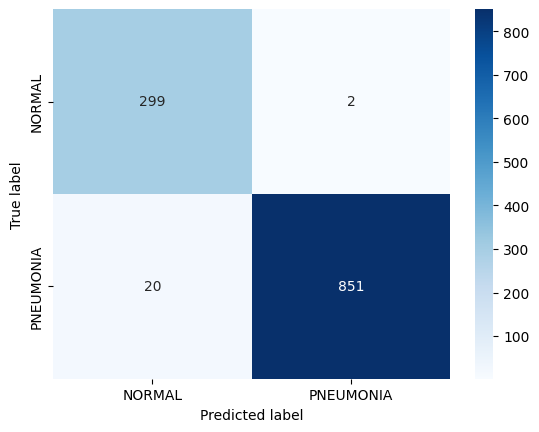

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix with a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
